  1%|          | 62/9000 [00:00<00:14, 613.71it/s]

100%|██████████| 9000/9000 [00:10<00:00, 876.93it/s]



217, 353, 545 :
  beta  = 1.599 (+0.209 / -0.195)
  T_eff = 11.764 K (+2.698 / -1.931)
  logA  = -26.071
  A_hat = 4.758e-12
  chi^2 = 0.239,  dof = 0 (reduced χ^2 undefined)

217, 353, 545, 857 :
  beta  = 1.570 (+0.136 / -0.134)
  T_eff = 12.102 K (+1.146 / -0.939)
  logA  = -26.127
  A_hat = 4.502e-12
  chi^2 = 0.328,  dof = 1,  reduced chi^2 = 0.328

353, 545, 857 :
  beta  = 1.481 (+0.235 / -0.239)
  T_eff = 12.622 K (+1.971 / -1.444)
  logA  = -26.193
  A_hat = 4.214e-12
  chi^2 = 0.070,  dof = 0 (reduced χ^2 undefined)


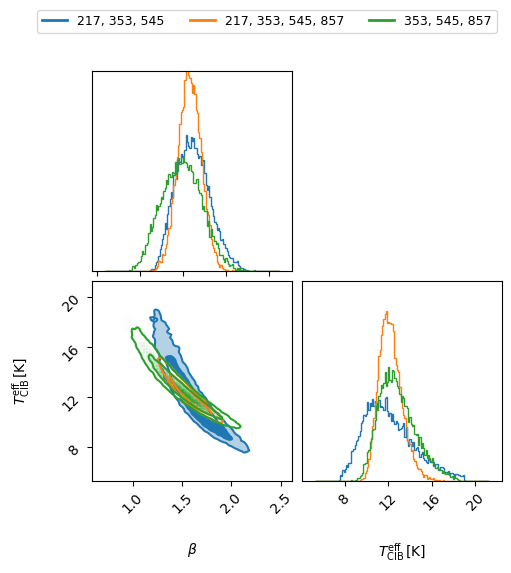

In [6]:
import numpy as np
from scipy.constants import h, k
import emcee
import corner
import matplotlib.pyplot as plt

# ======================================================
# 1. Data from Planck Table IV (CIB monopole)
#    Frequencies: 217, 353, 545, 857 GHz
# ======================================================
nu_ghz = np.array([217., 353., 545., 857.])   # GHz
nu_all = nu_ghz * 1e9                         # Hz

# ν Iν [nW m^-2 sr^-1] and 1σ errors (Table IV)
nuI_all   = np.array([0.077, 0.53, 2.3, 7.7])
sigma_nuI = np.array([0.003, 0.02, 0.1, 0.2])

# Convert ν Iν → Iν, so that d_ν has the same units/shape as Θ_ν^CIB
d_all     = nuI_all   / nu_all          # Iν
sigma_all = sigma_nuI / nu_all

# Index sets (ν subsets in Eq. 50)
idx_wo857 = np.array([0, 1, 2])         # 217, 353, 545         (no 857)
idx_w857  = np.array([0, 1, 2, 3])      # 217, 353, 545, 857   (with 857)
idx_hi    = np.array([1, 2, 3])         # 353, 545, 857        (no 217)


# ======================================================
# 2. CIB SED Θ_ν^CIB(β, T_eff)
#    From Eq. (46)+(48): Θ_ν ∝ (ν/ν0)^{β+3} / (exp(hν/kT) - 1)
# ======================================================
nu0_ghz = 353.0
nu0 = nu0_ghz * 1e9                      # pivot frequency in Hz

def theta_cib(nu, beta, T):
    """CIB SED shape Θ_ν^CIB(β, T_eff), up to a constant."""
    x = h * nu / (k * T)
    return (nu / nu0)**(beta + 3.0) / (np.exp(x) - 1.0)


# ======================================================
# 3. Posterior factory: Eq. (50) likelihood
#    Parameters: (beta, T_eff, logA)
#    tight_prior=True  -> Gaussian prior based on Table V (with 857 GHz)
# ======================================================
# Prior means / widths from Planck 4-band result (slightly broadened)
beta_mean = 1.60
beta_sigma = 0.30      # broader than 0.16 to stay conservative
T_mean = 12.0
T_sigma = 5.0          # broad: allow  ~[2,22] K at 2σ

def make_log_posterior(idx, tight_prior=False):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    def log_likelihood(theta):
        beta, T, logA = theta
        A = np.exp(logA)
        model = A * theta_cib(nu, beta, T)
        chi2 = np.sum((model - d)**2 * w)
        return -0.5 * chi2

    def log_prior(theta):
        beta, T, logA = theta

        # Broad top-hat for safety (same for both cases)
        if not (0.5 < beta < 2.5):
            return -np.inf
        if not (7.5 < T < 19):
            return -np.inf

        # Amplitude prior: keep it broad (do NOT tighten A)
        if not (-50.0 < logA < 10.0):
            return -np.inf

        if tight_prior:
            # Gaussian prior on (beta, T) based on Table V 4-band fit
            lp_beta = -0.5 * ((beta - beta_mean) / beta_sigma)**2
            lp_T    = -0.5 * ((T    - T_mean)   / T_sigma)**2
            return lp_beta + lp_T
        else:
            # effectively flat prior inside the top-hat
            return 0.0

    def log_posterior(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    return log_posterior


# ======================================================
# 4. Run MCMC for one case
# ======================================================
def run_chain(log_post, nwalkers=40, nsteps=9000):
    ndim = 3  # (beta, T, logA)
    p0_centre = np.array([1.6, 12.0, -20.0])
    p0 = p0_centre + 1e-2 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
    sampler.run_mcmc(p0, nsteps, progress=True)

    samples = sampler.get_chain(discard=nsteps // 2, thin=10, flat=True)
    return samples


# 4-band: broad prior; 3-band: informative prior on (beta,T)
logpost_wo857 = make_log_posterior(idx_wo857, tight_prior=True)
logpost_w857  = make_log_posterior(idx_w857,  tight_prior=True)
logpost_hi    = make_log_posterior(idx_hi,    tight_prior=True)

samp_wo857 = run_chain(logpost_wo857)
samp_w857  = run_chain(logpost_w857)
samp_hi    = run_chain(logpost_hi)

# 2D samples for plotting (β, T)
s_wo857_2d = samp_wo857[:, :2]
s_w857_2d  = samp_w857[:, :2]
s_hi_2d    = samp_hi[:, :2]


# ======================================================
# 5. Summaries & χ²/dof (3 fitted params: A, β, T)
# ======================================================
def chi2_for_theta(theta, idx):
    beta, T, logA = theta
    A = np.exp(logA)

    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    model = A * theta_cib(nu, beta, T)
    chi2 = np.sum((model - d)**2 * w)
    return chi2, A

def summarize(samples, idx, name):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84], axis=0)
    beta_16, T_16, logA_16 = q16
    beta_50, T_50, logA_50 = q50
    beta_84, T_84, logA_84 = q84

    chi2, A_hat = chi2_for_theta(q50, idx)
    dof = len(idx) - 3              # 3 free params
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    print(f"\n{name}:")
    print(f"  beta  = {beta_50:.3f} (+{beta_84-beta_50:.3f} / -{beta_50-beta_16:.3f})")
    print(f"  T_eff = {T_50:.3f} K (+{T_84-T_50:.3f} / -{T_50-T_16:.3f})")
    print(f"  logA  = {logA_50:.3f}")
    print(f"  A_hat = {A_hat:.3e}")
    if dof > 0:
        print(f"  chi^2 = {chi2:.3f},  dof = {dof},  reduced chi^2 = {red_chi2:.3f}")
    else:
        print(f"  chi^2 = {chi2:.3f},  dof = {dof} (reduced χ^2 undefined)")


summarize(samp_wo857, idx_wo857, "217, 353, 545 ")
summarize(samp_w857,  idx_w857,  "217, 353, 545, 857 ")
summarize(samp_hi,    idx_hi,    "353, 545, 857 ")


# ======================================================
# 6. Corner plot for (beta, T)
# ======================================================
labels = [r"$\beta$", r"$T_{\rm CIB}^{\rm eff}\,[\mathrm{K}]$"]

# Choose a range that contains all three posteriors
all_samp = np.vstack([s_wo857_2d, s_w857_2d, s_hi_2d])
beta_lo, beta_hi = np.percentile(all_samp[:, 0], [0.01, 99.99])
T_lo,    T_hi    = np.percentile(all_samp[:, 1], [0.01, 99.99])
pad_beta = 0.2 * (beta_hi - beta_lo)
pad_T    = 0.2 * (T_hi - T_lo)

ranges = [(beta_lo - pad_beta, beta_hi + pad_beta), (T_lo - pad_T, T_hi + pad_T)]

fig = corner.corner(
    s_wo857_2d,
    labels=labels,
    range=ranges,
    color="C0",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=True,
    bins=140,
)

corner.corner(
    s_w857_2d,
    fig=fig,
    range=ranges,
    color="C1",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=140,
)

corner.corner(
    s_hi_2d,
    fig=fig,
    range=ranges,
    color="C2",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=140,
)

from matplotlib.lines import Line2D
handles = [
    Line2D([], [], color="C0", lw=2),
    Line2D([], [], color="C1", lw=2),
    Line2D([], [], color="C2", lw=2),
]
labels_legend = [
    "217, 353, 545",
    "217, 353, 545, 857",
    "353, 545, 857",
]
fig.legend(
    handles,
    labels_legend,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
    fontsize=9,
)

# ---- add extra vertical headroom for the diagonal histograms ----
import numpy as np

# for 2 parameters, corner gives a 2x2 grid of axes
axes = np.array(fig.axes).reshape(2, 2)

# diagonal panels: top-left (β) and bottom-right (T_eff)
diag_axes = [axes[0, 0], axes[1, 1]]

# diag_axes already defined as [axes[0,0], axes[1,1]]
for ax in diag_axes:
    # 1) More headroom in y
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.6)   # 40% extra space above the tallest bar

    # 2) Slightly wider x-range
    xmin, xmax = ax.get_xlim()
    x_center = 0.5 * (xmin + xmax)
    x_half   = 0.5 * (xmax - xmin)
    x_half_new = x_half * 1.15       # 5% wider; bump to 1.1 if you want more
    ax.set_xlim(x_center - x_half_new, x_center + x_half_new)

plt.show()


100%|██████████| 15000/15000 [00:20<00:00, 726.77it/s]



217, 353, 545, 857 (fit A, beta, T):
  beta  = 1.559 (+0.153 / -0.156)
  T_eff = 12.183 K (+1.393 / -1.072)
  logA  = -26.138
  A_hat = 4.448e-12
  chi^2 = 0.342,  dof = 1,  reduced chi^2 = 0.342

217, 353, 545 (A fixed = 4.448e-12):
  beta  = 1.562 (+0.060 / -0.060)
  T_eff = 12.181 K (+0.143 / -0.144)
  chi^2 = 0.341,  dof = 1,  reduced chi^2 = 0.341

353, 545, 857 (A fixed = 4.448e-12):
  beta  = 1.527 (+0.083 / -0.079)
  T_eff = 12.272 K (+0.228 / -0.232)
  chi^2 = 0.137,  dof = 1,  reduced chi^2 = 0.137


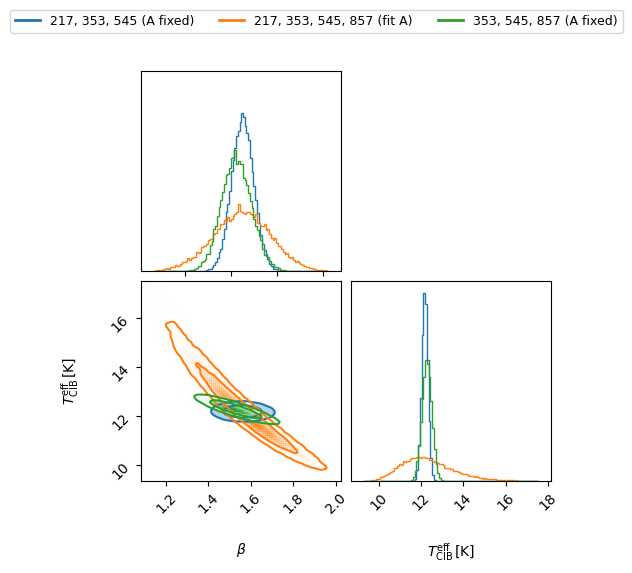

In [1]:
import numpy as np
from scipy.constants import h, k
import emcee
import corner
import matplotlib.pyplot as plt

# ======================================================
# 1. Data from Planck Table IV (CIB monopole)
#    Frequencies: 217, 353, 545, 857 GHz
# ======================================================
nu_ghz = np.array([217., 353., 545., 857.])   # GHz
nu_all = nu_ghz * 1e9                         # Hz

# ν Iν [nW m^-2 sr^-1] and 1σ errors (Table IV)
nuI_all   = np.array([0.077, 0.53, 2.3, 7.7])
sigma_nuI = np.array([0.003, 0.02, 0.1, 0.2])

# Convert ν Iν → Iν, so that d_ν has the same units/shape as Θ_ν^CIB
d_all     = nuI_all   / nu_all          # Iν
sigma_all = sigma_nuI / nu_all

# Index sets
idx_217_353_545   = np.array([0, 1, 2])   # 217, 353, 545
idx_217_353_545_857 = np.array([0, 1, 2, 3])  # 217, 353, 545, 857
idx_353_545_857   = np.array([1, 2, 3])   # 353, 545, 857


# ======================================================
# 2. CIB SED Θ_ν^CIB(β, T_eff)
#    From Eq. (46)+(48): Θ_ν ∝ (ν/ν0)^{β+3} / (exp(hν/kT) - 1)
# ======================================================
nu0_ghz = 353.0
nu0 = nu0_ghz * 1e9                      # pivot frequency in Hz

def theta_cib(nu, beta, T):
    """CIB SED shape Θ_ν^CIB(β, T_eff), up to an overall constant."""
    x = h * nu / (k * T)
    return (nu / nu0)**(beta + 3.0) / (np.exp(x) - 1.0)


# ======================================================
# 3. 4-band posterior: fit (beta, T, logA) with broad priors
# ======================================================
def make_log_posterior_4band(idx):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    def log_likelihood(theta):
        beta, T, logA = theta
        A = np.exp(logA)
        model = A * theta_cib(nu, beta, T)
        chi2 = np.sum((model - d)**2 * w)
        return -0.5 * chi2

    def log_prior(theta):
        beta, T, logA = theta
        # Broad top-hat for beta, T
        if not (0.0 < beta < 4.0):
            return -np.inf
        if not (2.0 < T < 50.0):
            return -np.inf
        # Broad top-hat for amplitude
        if not (-50.0 < logA < 10.0):
            return -np.inf
        return 0.0

    def log_post(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    return log_post


def run_chain(log_post, ndim, nwalkers=40, nsteps=15000, p0_centre=None):
    if p0_centre is None:
        p0_centre = np.zeros(ndim)
    p0 = p0_centre + 1e-2 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.get_chain(discard=nsteps//2, thin=10, flat=True)
    return samples


logpost_4 = make_log_posterior_4band(idx_217_353_545_857)
# Start near Planck-ish values
p0_centre_4 = np.array([1.6, 12.0, -26.0])
samp_4 = run_chain(logpost_4, ndim=3, p0_centre=p0_centre_4)

# Median parameters for 4-band fit
q16_4, q50_4, q84_4 = np.percentile(samp_4, [16, 50, 84], axis=0)
beta_50_4, T_50_4, logA_50_4 = q50_4
A_fid = np.exp(logA_50_4)   # this is the amplitude we will FIX for 3-band fits


# ======================================================
# 4. 3-band posteriors: fit only (beta, T) with A fixed = A_fid
#    Use informative Gaussian prior on (beta, T) based on 4-band result
# ======================================================
beta_mean = beta_50_4
beta_sigma = 0.30   # slightly broader than 4-band error
T_mean = T_50_4
T_sigma = 5.0       # broad prior on T


def make_log_posterior_3band_fixedA(idx, A_fixed, use_informative_prior=True):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    def log_likelihood(theta):
        beta, T = theta
        model = A_fixed * theta_cib(nu, beta, T)
        chi2 = np.sum((model - d)**2 * w)
        return -0.5 * chi2

    def log_prior(theta):
        beta, T = theta

        # Broad top-hat bounds
        if not (0.0 < beta < 4.0):
            return -np.inf
        if not (2.0 < T < 50.0):
            return -np.inf

        if use_informative_prior:
            lp_beta = -0.5 * ((beta - beta_mean) / beta_sigma)**2
            lp_T    = -0.5 * ((T    - T_mean)   / T_sigma)**2
            return lp_beta + lp_T
        else:
            return 0.0

    def log_post(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    return log_post


logpost_217_353_545 = make_log_posterior_3band_fixedA(idx_217_353_545, A_fid, use_informative_prior=True)
logpost_353_545_857 = make_log_posterior_3band_fixedA(idx_353_545_857, A_fid, use_informative_prior=True)

# Run 3-band chains (2D: beta, T)
p0_centre_3 = np.array([beta_mean, T_mean])
samp_217_353_545 = run_chain(logpost_217_353_545, ndim=2, p0_centre=p0_centre_3)
samp_353_545_857 = run_chain(logpost_353_545_857, ndim=2, p0_centre=p0_centre_3)

s_4_2d            = samp_4[:, :2]
s_217_353_545_2d  = samp_217_353_545
s_353_545_857_2d  = samp_353_545_857


# ======================================================
# 5. χ² and summaries
# ======================================================
def chi2_for_beta_T(beta, T, idx, A_fixed):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    model = A_fixed * theta_cib(nu, beta, T)
    chi2 = np.sum((model - d)**2 * w)
    return chi2

def summarize_4band(samples, idx, name):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84], axis=0)
    beta_16, T_16, logA_16 = q16
    beta_50, T_50, logA_50 = q50
    beta_84, T_84, logA_84 = q84

    A_hat = np.exp(logA_50)
    chi2 = chi2_for_beta_T(beta_50, T_50, idx, A_hat)
    dof = len(idx) - 3
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    print(f"\n{name}:")
    print(f"  beta  = {beta_50:.3f} (+{beta_84-beta_50:.3f} / -{beta_50-beta_16:.3f})")
    print(f"  T_eff = {T_50:.3f} K (+{T_84-T_50:.3f} / -{T_50-T_16:.3f})")
    print(f"  logA  = {logA_50:.3f}")
    print(f"  A_hat = {A_hat:.3e}")
    print(f"  chi^2 = {chi2:.3f},  dof = {dof},  reduced chi^2 = {red_chi2:.3f}")


def summarize_3band(samples, idx, name, A_fixed):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84], axis=0)
    beta_16, T_16 = q16
    beta_50, T_50 = q50
    beta_84, T_84 = q84

    chi2 = chi2_for_beta_T(beta_50, T_50, idx, A_fixed)
    dof = len(idx) - 2   # only beta, T are free
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    print(f"\n{name} (A fixed = {A_fixed:.3e}):")
    print(f"  beta  = {beta_50:.3f} (+{beta_84-beta_50:.3f} / -{beta_50-beta_16:.3f})")
    print(f"  T_eff = {T_50:.3f} K (+{T_84-T_50:.3f} / -{T_50-T_16:.3f})")
    print(f"  chi^2 = {chi2:.3f},  dof = {dof},  reduced chi^2 = {red_chi2:.3f}")


summarize_4band(samp_4, idx_217_353_545_857, "217, 353, 545, 857 (fit A, beta, T)")
summarize_3band(samp_217_353_545, idx_217_353_545, "217, 353, 545", A_fid)
summarize_3band(samp_353_545_857, idx_353_545_857, "353, 545, 857", A_fid)


# ======================================================
# 6. Corner plot for (beta, T)
# ======================================================
labels = [r"$\beta$", r"$T_{\rm CIB}^{\rm eff}\,[\mathrm{K}]$"]

all_samp_2d = np.vstack([s_4_2d, s_217_353_545_2d, s_353_545_857_2d])
beta_lo, beta_hi = np.percentile(all_samp_2d[:, 0], [0.1, 99.9])
T_lo,    T_hi    = np.percentile(all_samp_2d[:, 1], [0.1, 99.9])
pad_beta = 0.05 * (beta_hi - beta_lo)
pad_T    = 0.05 * (T_hi - T_lo)
ranges = [(beta_lo - pad_beta, beta_hi + pad_beta),
          (T_lo   - pad_T,     T_hi   + pad_T)]

fig = corner.corner(
    s_217_353_545_2d,
    labels=labels,
    range=ranges,
    color="C0",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=True,
    bins=100,
)

corner.corner(
    s_4_2d,
    fig=fig,
    range=ranges,
    color="C1",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=100,
)

corner.corner(
    s_353_545_857_2d,
    fig=fig,
    range=ranges,
    color="C2",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=100,
)

from matplotlib.lines import Line2D
handles = [
    Line2D([], [], color="C0", lw=2),
    Line2D([], [], color="C1", lw=2),
    Line2D([], [], color="C2", lw=2),
]
labels_legend = [
    r"217, 353, 545 (A fixed)",
    r"217, 353, 545, 857 (fit A)",
    r"353, 545, 857 (A fixed)",
]
fig.legend(
    handles,
    labels_legend,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
    fontsize=9,
)


# ---- add extra vertical headroom for the diagonal histograms ----
import numpy as np

# for 2 parameters, corner gives a 2x2 grid of axes
axes = np.array(fig.axes).reshape(2, 2)

# diagonal panels: top-left (β) and bottom-right (T_eff)
diag_axes = [axes[0, 0], axes[1, 1]]

# diag_axes already defined as [axes[0,0], axes[1,1]]
for ax in diag_axes:
    # 1) More headroom in y
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.5)   # 40% extra space above the tallest bar

    # 2) Slightly wider x-range
    xmin, xmax = ax.get_xlim()
    x_center = 0.5 * (xmin + xmax)
    x_half   = 0.5 * (xmax - xmin)
    x_half_new = x_half * 1.15       # 5% wider; bump to 1.1 if you want more
    ax.set_xlim(x_center - x_half_new, x_center + x_half_new)

plt.show()


100%|██████████| 15000/15000 [00:19<00:00, 770.37it/s]



217, 353, 545  (A fixed = 4.758e-12)
  beta  = 1.598 (+0.062 / -0.062)
  T_eff = 11.767 K (+0.137 / -0.137)
  chi^2 = 0.237,  dof = 1,  reduced chi^2 = 0.237

217, 353, 545, 857  (A fixed = 4.502e-12)
  beta  = 1.570 (+0.043 / -0.042)
  T_eff = 12.105 K (+0.122 / -0.123)
  chi^2 = 0.324,  dof = 2,  reduced chi^2 = 0.162

353, 545, 857  (A fixed = 4.214e-12)
  beta  = 1.469 (+0.086 / -0.080)
  T_eff = 12.660 K (+0.246 / -0.255)
  chi^2 = 0.055,  dof = 1,  reduced chi^2 = 0.055


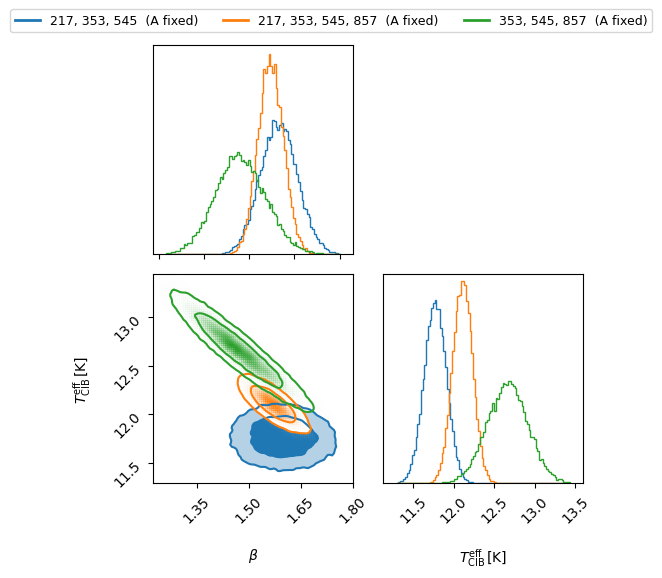

In [ ]:
import numpy as np
from scipy.constants import h, k
import emcee
import corner
import matplotlib.pyplot as plt

# ======================================================
# 1. Data from Planck Table IV (CIB monopole)
#    Frequencies: 217, 353, 545, 857 GHz
# ======================================================
nu_ghz = np.array([217., 353., 545., 857.])   # GHz
nu_all = nu_ghz * 1e9                         # Hz

# ν Iν [nW m^-2 sr^-1] and 1σ errors (Table IV)
nuI_all   = np.array([0.077, 0.53, 2.3, 7.7])
sigma_nuI = np.array([0.003, 0.02, 0.1, 0.2])

# Convert ν Iν → Iν
d_all     = nuI_all   / nu_all          # Iν
sigma_all = sigma_nuI / nu_all

# Index sets
idx_low   = np.array([0, 1, 2])         # 217, 353, 545
idx_full  = np.array([0, 1, 2, 3])      # 217, 353, 545, 857
idx_high  = np.array([1, 2, 3])         # 353, 545, 857

# ======================================================
# 2. CIB SED Θ_ν^CIB(β, T_eff)
#    Θ_ν ∝ (ν/ν0)^{β+3} / (exp(hν/kT) - 1)
# ======================================================
nu0_ghz = 353.0
nu0 = nu0_ghz * 1e9

def theta_cib(nu, beta, T):
    """CIB SED shape Θ_ν^CIB(β, T_eff), up to an overall constant."""
    x = h * nu / (k * T)
    return (nu / nu0)**(beta + 3.0) / (np.exp(x) - 1.0)


# ======================================================
# 3. Posterior factory with A FIXED
#    Parameters: (beta, T_eff) only
# ======================================================
def make_log_posterior_fixedA(idx, A_fixed):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    def log_likelihood(theta):
        beta, T = theta
        model = A_fixed * theta_cib(nu, beta, T)
        chi2 = np.sum((model - d)**2 * w)
        return -0.5 * chi2

    def log_prior(theta):
        beta, T = theta
        # broad but sensible top-hat priors
        if not (0.0 < beta < 4.0):
            return -np.inf
        if not (2.0 < T < 50.0):
            return -np.inf
        return 0.0

    def log_post(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    return log_post


# ======================================================
# 4. Run MCMC for one case
# ======================================================
def run_chain(log_post, nwalkers=40, nsteps=15000, beta0=1.6, T0=12.0):
    ndim = 2  # (beta, T)
    p0_centre = np.array([beta0, T0])
    p0 = p0_centre + 1e-2 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.get_chain(discard=nsteps//2, thin=10, flat=True)
    return samples


# ======================================================
# 5. Use your measured A values (from previous free-A fits)
# ======================================================
A_low   = 4.758e-12  # 217,353,545
A_full  = 4.502e-12  # 217,353,545,857
A_high  = 4.214e-12  # 353,545,857

logpost_low  = make_log_posterior_fixedA(idx_low,  A_low)
logpost_full = make_log_posterior_fixedA(idx_full, A_full)
logpost_high = make_log_posterior_fixedA(idx_high, A_high)

s_low  = run_chain(logpost_low)
s_full = run_chain(logpost_full)
s_high = run_chain(logpost_high)


# ======================================================
# 6. χ², dof, reduced χ², summaries
# ======================================================
def chi2_for_beta_T(beta, T, idx, A_fixed):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2
    model = A_fixed * theta_cib(nu, beta, T)
    chi2 = np.sum((model - d)**2 * w)
    return chi2

def summarize(samples, idx, A_fixed, name):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84], axis=0)
    beta_16, T_16 = q16
    beta_50, T_50 = q50
    beta_84, T_84 = q84

    chi2 = chi2_for_beta_T(beta_50, T_50, idx, A_fixed)
    dof  = len(idx) - 2   # only beta and T are free
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    print(f"\n{name}  (A fixed = {A_fixed:.3e})")
    print(f"  beta  = {beta_50:.3f} (+{beta_84-beta_50:.3f} / -{beta_50-beta_16:.3f})")
    print(f"  T_eff = {T_50:.3f} K (+{T_84-T_50:.3f} / -{T_50-T_16:.3f})")
    print(f"  chi^2 = {chi2:.3f},  dof = {dof},  reduced chi^2 = {red_chi2:.3f}")

    return np.array([beta_50, T_50]), np.array([beta_16, T_16]), np.array([beta_84, T_84])

summarize(s_low,  idx_low,  A_low,  "217, 353, 545")
summarize(s_full, idx_full, A_full, "217, 353, 545, 857")
summarize(s_high, idx_high, A_high, "353, 545, 857")


# ======================================================
# 7. Corner plot for (beta, T_eff)
# ======================================================
s_low_2d  = s_low
s_full_2d = s_full
s_high_2d = s_high

labels = [r"$\beta$", r"$T_{\rm CIB}^{\rm eff}\,[\mathrm{K}]$"]

# choose a box that comfortably contains all three posteriors
all_samp = np.vstack([s_low_2d, s_full_2d, s_high_2d])
beta_lo, beta_hi = np.percentile(all_samp[:, 0], [0.1, 99.9])
T_lo,    T_hi    = np.percentile(all_samp[:, 1], [0.1, 99.9])
pad_beta = 0.05 * (beta_hi - beta_lo)
pad_T    = 0.05 * (T_hi - T_lo)
ranges = [(beta_lo - pad_beta, beta_hi + pad_beta),
          (T_lo   - pad_T,     T_hi   + pad_T)]

fig = corner.corner(
    s_low_2d,
    labels=labels,
    range=ranges,
    color="C0",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=True,
    bins=100,
)

corner.corner(
    s_full_2d,
    fig=fig,
    range=ranges,
    color="C1",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=100,
)

corner.corner(
    s_high_2d,
    fig=fig,
    range=ranges,
    color="C2",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=100,
)

from matplotlib.lines import Line2D
handles = [
    Line2D([], [], color="C0", lw=2),
    Line2D([], [], color="C1", lw=2),
    Line2D([], [], color="C2", lw=2),
]
labels_legend = [
    r"217, 353, 545  (A fixed)",
    r"217, 353, 545, 857  (A fixed)",
    r"353, 545, 857  (A fixed)",
]
fig.legend(
    handles,
    labels_legend,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
    fontsize=9,
)

# ---- add extra vertical headroom for the diagonal histograms ----
import numpy as np

# for 2 parameters, corner gives a 2x2 grid of axes
axes = np.array(fig.axes).reshape(2, 2)

# diagonal panels: top-left (β) and bottom-right (T_eff)
diag_axes = [axes[0, 0], axes[1, 1]]

# diag_axes already defined as [axes[0,0], axes[1,1]]
for ax in diag_axes:
    # 1) More headroom in y
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.85)   # 85% extra space above the tallest bar

    # 2) Slightly wider x-range
    xmin, xmax = ax.get_xlim()
    x_center = 0.5 * (xmin + xmax)
    x_half   = 0.5 * (xmax - xmin)
    x_half_new = x_half * 1.15       # 15% wider; bump to 1.1 if you want more
    ax.set_xlim(x_center - x_half_new, x_center + x_half_new)

plt.tight_layout()
plt.show()


100%|██████████| 15000/15000 [00:19<00:00, 755.96it/s]



217, 353, 545, 857 (fit A, beta, T):
  beta  = 1.564 (+0.154 / -0.150)
  T_eff = 12.150 K (+1.322 / -1.066)
  logA  = -26.134
  A_hat = 4.468e-12
  chi^2 = 0.338,  dof = 1,  reduced chi^2 = 0.338

217, 353, 545 (A fixed = 4.468e-12):
  beta  = 1.565 (+0.060 / -0.061)
  T_eff = 12.152 K (+0.143 / -0.145)
  chi^2 = 0.334,  dof = 1,  reduced chi^2 = 0.334

353, 545, 857 (A fixed = 4.468e-12):
  beta  = 1.532 (+0.083 / -0.080)
  T_eff = 12.243 K (+0.231 / -0.233)
  chi^2 = 0.143,  dof = 1,  reduced chi^2 = 0.143


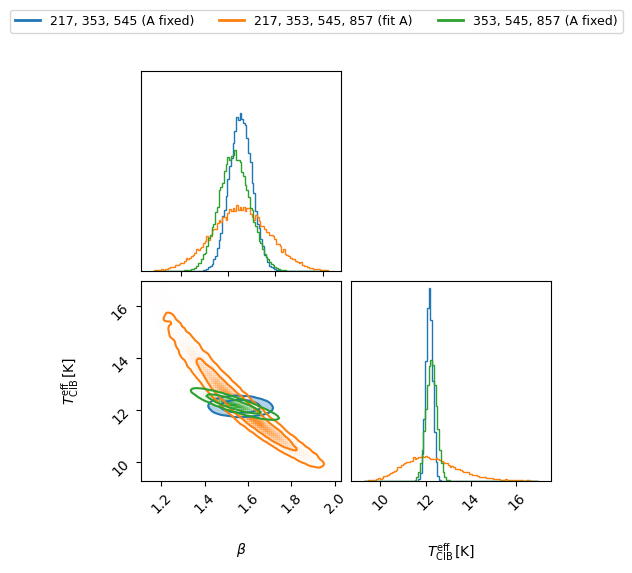


CIB mixing vector in T_CMB units:
  217 GHz: 16992213156827410.000000
  353 GHz: 112743679484837152.000000
  545 GHz: 1678251854996805888.000000
  857 GHz: 139687276172381028352.000000


In [1]:
import numpy as np
from scipy.constants import h, k, c   ### NEW: add c
import emcee
import corner
import matplotlib.pyplot as plt

# ======================================================
# 1. Data from Planck Table IV (CIB monopole)
#    Frequencies: 217, 353, 545, 857 GHz
# ======================================================
nu_ghz = np.array([217., 353., 545., 857.])   # GHz
nu_all = nu_ghz * 1e9                         # Hz

# ν Iν [nW m^-2 sr^-1] and 1σ errors (Table IV)
nuI_all   = np.array([0.077, 0.53, 2.3, 7.7])
sigma_nuI = np.array([0.003, 0.02, 0.1, 0.2])

# Convert ν Iν → Iν, so that d_ν has the same units/shape as Θ_ν^CIB
d_all     = nuI_all   / nu_all          # Iν (up to nW↔W factor absorbed into A)
sigma_all = sigma_nuI / nu_all

# Index sets
idx_217_353_545     = np.array([0, 1, 2])      # 217, 353, 545
idx_217_353_545_857 = np.array([0, 1, 2, 3])   # 217, 353, 545, 857
idx_353_545_857     = np.array([1, 2, 3])      # 353, 545, 857


# ======================================================
# 2. CIB SED Θ_ν^CIB(β, T_eff) in INTENSITY units (shape only)
#    From Eq. (46)+(48): Θ_ν ∝ (ν/ν0)^{β+3} / (exp(hν/kT) - 1)
# ======================================================
nu0_ghz = 353.0
nu0 = nu0_ghz * 1e9                      # pivot frequency in Hz

def theta_cib(nu, beta, T):
    """CIB SED shape Θ_ν^CIB(β, T_eff), up to an overall constant (INTENSITY)."""
    x = h * nu / (k * T)
    return (nu / nu0)**(beta + 3.0) / (np.exp(x) - 1.0)


# ======================================================
# 3. 4-band posterior: fit (beta, T, logA) with broad priors
# ======================================================
def make_log_posterior_4band(idx):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    def log_likelihood(theta):
        beta, T, logA = theta
        A = np.exp(logA)
        model = A * theta_cib(nu, beta, T)
        chi2 = np.sum((model - d)**2 * w)
        return -0.5 * chi2

    def log_prior(theta):
        beta, T, logA = theta
        # Broad top-hat for beta, T
        if not (0.0 < beta < 4.0):
            return -np.inf
        if not (2.0 < T < 50.0):
            return -np.inf
        # Broad top-hat for amplitude
        if not (-50.0 < logA < 10.0):
            return -np.inf
        return 0.0

    def log_post(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    return log_post


def run_chain(log_post, ndim, nwalkers=40, nsteps=15000, p0_centre=None):
    if p0_centre is None:
        p0_centre = np.zeros(ndim)
    p0 = p0_centre + 1e-2 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
    sampler.run_mcmc(p0, nsteps, progress=True)
    samples = sampler.get_chain(discard=nsteps//2, thin=10, flat=True)
    return samples


logpost_4 = make_log_posterior_4band(idx_217_353_545_857)
# Start near Planck-ish values
p0_centre_4 = np.array([1.6, 12.0, -26.0])
samp_4 = run_chain(logpost_4, ndim=3, p0_centre=p0_centre_4)

# Median parameters for 4-band fit
q16_4, q50_4, q84_4 = np.percentile(samp_4, [16, 50, 84], axis=0)
beta_50_4, T_50_4, logA_50_4 = q50_4
A_fid = np.exp(logA_50_4)   # this is the amplitude we will FIX for 3-band fits


# ======================================================
# 4. 3-band posteriors: fit only (beta, T) with A fixed = A_fid
#    Use informative Gaussian prior on (beta, T) based on 4-band result
# ======================================================
beta_mean = beta_50_4
beta_sigma = 0.30   # slightly broader than 4-band error
T_mean = T_50_4
T_sigma = 5.0       # broad prior on T


def make_log_posterior_3band_fixedA(idx, A_fixed, use_informative_prior=True):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    def log_likelihood(theta):
        beta, T = theta
        model = A_fixed * theta_cib(nu, beta, T)
        chi2 = np.sum((model - d)**2 * w)
        return -0.5 * chi2

    def log_prior(theta):
        beta, T = theta

        # Broad top-hat bounds
        if not (0.0 < beta < 4.0):
            return -np.inf
        if not (2.0 < T < 50.0):
            return -np.inf

        if use_informative_prior:
            lp_beta = -0.5 * ((beta - beta_mean) / beta_sigma)**2
            lp_T    = -0.5 * ((T    - T_mean)   / T_sigma)**2
            return lp_beta + lp_T
        else:
            return 0.0

    def log_post(theta):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta)

    return log_post


logpost_217_353_545 = make_log_posterior_3band_fixedA(idx_217_353_545, A_fid, use_informative_prior=True)
logpost_353_545_857 = make_log_posterior_3band_fixedA(idx_353_545_857, A_fid, use_informative_prior=True)

# Run 3-band chains (2D: beta, T)
p0_centre_3 = np.array([beta_mean, T_mean])
samp_217_353_545 = run_chain(logpost_217_353_545, ndim=2, p0_centre=p0_centre_3)
samp_353_545_857 = run_chain(logpost_353_545_857, ndim=2, p0_centre=p0_centre_3)

s_4_2d            = samp_4[:, :2]
s_217_353_545_2d  = samp_217_353_545
s_353_545_857_2d  = samp_353_545_857


# ======================================================
# 5. χ² and summaries
# ======================================================
def chi2_for_beta_T(beta, T, idx, A_fixed):
    nu    = nu_all[idx]
    d     = d_all[idx]
    sigma = sigma_all[idx]
    w     = 1.0 / sigma**2

    model = A_fixed * theta_cib(nu, beta, T)
    chi2 = np.sum((model - d)**2 * w)
    return chi2

def summarize_4band(samples, idx, name):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84], axis=0)
    beta_16, T_16, logA_16 = q16
    beta_50, T_50, logA_50 = q50
    beta_84, T_84, logA_84 = q84

    A_hat = np.exp(logA_50)
    chi2 = chi2_for_beta_T(beta_50, T_50, idx, A_hat)
    dof = len(idx) - 3
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    print(f"\n{name}:")
    print(f"  beta  = {beta_50:.3f} (+{beta_84-beta_50:.3f} / -{beta_50-beta_16:.3f})")
    print(f"  T_eff = {T_50:.3f} K (+{T_84-T_50:.3f} / -{T_50-T_16:.3f})")
    print(f"  logA  = {logA_50:.3f}")
    print(f"  A_hat = {A_hat:.3e}")
    print(f"  chi^2 = {chi2:.3f},  dof = {dof},  reduced chi^2 = {red_chi2:.3f}")


def summarize_3band(samples, idx, name, A_fixed):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84], axis=0)
    beta_16, T_16 = q16
    beta_50, T_50 = q50
    beta_84, T_84 = q84

    chi2 = chi2_for_beta_T(beta_50, T_50, idx, A_fixed)
    dof = len(idx) - 2   # only beta, T are free
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    print(f"\n{name} (A fixed = {A_fixed:.3e}):")
    print(f"  beta  = {beta_50:.3f} (+{beta_84-beta_50:.3f} / -{beta_50-beta_16:.3f})")
    print(f"  T_eff = {T_50:.3f} K (+{T_84-T_50:.3f} / -{T_50-T_16:.3f})")
    print(f"  chi^2 = {chi2:.3f},  dof = {dof},  reduced chi^2 = {red_chi2:.3f}")


summarize_4band(samp_4, idx_217_353_545_857, "217, 353, 545, 857 (fit A, beta, T)")
summarize_3band(samp_217_353_545, idx_217_353_545, "217, 353, 545", A_fid)
summarize_3band(samp_353_545_857, idx_353_545_857, "353, 545, 857", A_fid)


# ======================================================
# 6. Corner plot for (beta, T)
# ======================================================
labels = [r"$\beta$", r"$T_{\rm CIB}^{\rm eff}\,[\mathrm{K}]$"]

all_samp_2d = np.vstack([s_4_2d, s_217_353_545_2d, s_353_545_857_2d])
beta_lo, beta_hi = np.percentile(all_samp_2d[:, 0], [0.1, 99.9])
T_lo,    T_hi    = np.percentile(all_samp_2d[:, 1], [0.1, 99.9])
pad_beta = 0.05 * (beta_hi - beta_lo)
pad_T    = 0.05 * (T_hi - T_lo)
ranges = [(beta_lo - pad_beta, beta_hi + pad_beta),
          (T_lo   - pad_T,     T_hi   + pad_T)]

fig = corner.corner(
    s_217_353_545_2d,
    labels=labels,
    range=ranges,
    color="C0",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=True,
    bins=100,
)

corner.corner(
    s_4_2d,
    fig=fig,
    range=ranges,
    color="C1",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=100,
)

corner.corner(
    s_353_545_857_2d,
    fig=fig,
    range=ranges,
    color="C2",
    levels=[0.68, 0.95],
    plot_datapoints=False,
    smooth=1.0,
    fill_contours=False,
    bins=100,
)

from matplotlib.lines import Line2D
handles = [
    Line2D([], [], color="C0", lw=2),
    Line2D([], [], color="C1", lw=2),
    Line2D([], [], color="C2", lw=2),
]
labels_legend = [
    r"217, 353, 545 (A fixed)",
    r"217, 353, 545, 857 (fit A)",
    r"353, 545, 857 (A fixed)",
]
fig.legend(
    handles,
    labels_legend,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=3,
    fontsize=9,
)


# ---- add extra vertical headroom for the diagonal histograms ----
import numpy as np

axes = np.array(fig.axes).reshape(2, 2)
diag_axes = [axes[0, 0], axes[1, 1]]
for ax in diag_axes:
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.5)
    xmin, xmax = ax.get_xlim()
    x_center = 0.5 * (xmin + xmax)
    x_half   = 0.5 * (xmax - xmin)
    x_half_new = x_half * 1.15
    ax.set_xlim(x_center - x_half_new, x_center + x_half_new)

plt.show()


# ======================================================
# 7. Build CIB mixing vector in T_CMB units (for ILC)
# ======================================================
T_cmb = 2.7255  ### NEW

def dBdT_cmb(nu):
    """
    dB_nu/dT at T_CMB, in SI units: W m^-2 Hz^-1 sr^-1 K^-1
    """
    x  = h * nu / (k * T_cmb)
    ex = np.exp(x)
    prefac = 2.0 * h**2 * nu**4 / (c**2 * k * T_cmb**2)
    return prefac * ex / (ex - 1.0)**2

# Choose fiducial (beta, T_eff) — e.g. from 353, 545, 857 fit:
q16_3, q50_3, q84_3 = np.percentile(samp_353_545_857, [16, 50, 84], axis=0)
beta_fid, T_fid = q50_3   # you can also use (beta_50_4, T_50_4) if you prefer 4-band

# 1) CIB SED in INTENSITY shape
sed_I = theta_cib(nu_all, beta_fid, T_fid)

# 2) Convert to T_CMB SED: divide by dB/dT
g_nu = dBdT_cmb(nu_all)
sed_T = sed_I / g_nu    # CIB mixing vector in K_CMB, up to an overall constant

print("\nCIB mixing vector in T_CMB units:")
for nu_g, val in zip(nu_ghz, sed_T ):
    print(f"  {nu_g:>3.0f} GHz: {val:.6f}")
